In [ ]:
from google.colab import drive
drive.mount("Problem")

Mounted at Problem


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.externals import joblib 
import nltk
# nltk.download('stopwords')
# print('Downloaded Stopwords')
from nltk.corpus import stopwords
import re
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
stop_words = STOP_WORDS
import string
punctuations = string.punctuation
from sklearn.feature_extraction.text import HashingVectorizer

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#seting up the root DTR
Root_DTR ="Problem/MyDrive/Problem/"

In [ ]:
# Reading dataset
train =pd.read_csv(Root_DTR+'dataset/train_file.csv')
test = pd.read_csv(Root_DTR+'dataset/test_file.csv')

In [ ]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [ ]:
train.loc[0,'Headline']

'Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor'

In [ ]:
train.loc[0,'Title']

'Obama Lays Wreath at Arlington National Cemetery'

In [ ]:
test.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
0,tFrqIR6Chj,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,BusinessDay,economy,2016-03-29 01:41:12,0,0,1
1,DVAaGErjlF,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,Daily Mail,microsoft,2016-03-29 01:41:27,121,2,13
2,OT9UIZm5M2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,EURweb,microsoft,2016-03-29 01:47:00,12,1,0
3,lflGp3q2Fj,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,Bloomberg via Yahoo! Finance,economy,2016-03-29 02:00:00,0,0,3
4,zDYG0SoovZ,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",FXStreet,economy,2016-03-29 02:01:07,3,0,0


In [ ]:
# We check missing value 
missing_val = pd.DataFrame(train.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,0
3,Source,175
4,Topic,0
5,PublishDate,0
6,Facebook,0
7,GooglePlus,0
8,LinkedIn,0
9,SentimentTitle,0


In [ ]:
train[train['Source'].isna()]

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
6,lKg2pImhCl,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",NaN,palestine,2016-02-28 14:03:00,0,0,0,0.000000,-0.005906
56,ZOKue2cqfO,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 09:29:00,0,0,0,0.000000,0.048546
111,JXfRvxs0R6,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 00:15:00,0,0,0,-0.243068,0.048546
350,A1YOXDsuOO,Human rights situation in Palestinian territor...,In a special meeting convened by the UN Human ...,NaN,palestine,2015-10-28 17:24:00,-1,-1,-1,-0.228299,-0.124931
409,fO2mYsUg5P,Japan Contributes $5.73M To UNRWA’s Food Assis...,"JERUSALEM, October 31, 2015 (WAFA) – The Japan...",NaN,palestine,2015-10-31 04:30:00,-1,-1,-1,0.166667,-0.042878
...,...,...,...,...,...,...,...,...,...,...,...
55482,FJZonPtvqe,"Monday, 28 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 04:35:00,0,0,0,-0.243068,0.068465
55483,NanKfuNzsO,"Saturday, 16 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 04:36:00,-1,-1,-1,0.000000,0.068465
55486,ovFBb4XFt4,"Sunday, 17 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 05:07:00,-1,-1,-1,0.000000,0.068465
55620,H2PlLqiX9U,"Tuesday, 29 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 14:06:00,0,0,0,-0.243068,0.068465


In [ ]:
train.dropna(inplace=True)

In [ ]:
import os,string

In [ ]:
test['Source'].fillna(test['Source'].mode()[0], inplace=True)


EDA - Data Visualization

In [ ]:
sns.set(style='darkgrid',palette='Set1')

In [ ]:
import math as math
import seaborn as sns


AttributeError: ignored

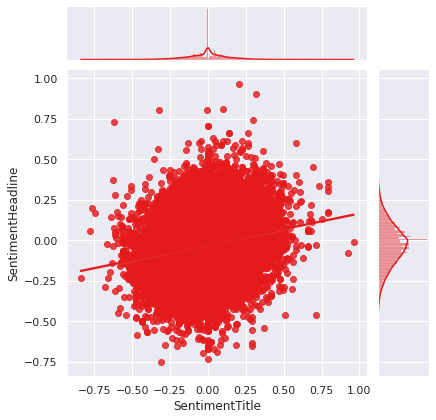

In [ ]:
sns.jointplot(x='SentimentTitle',y='SentimentHeadline',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
plt.show()

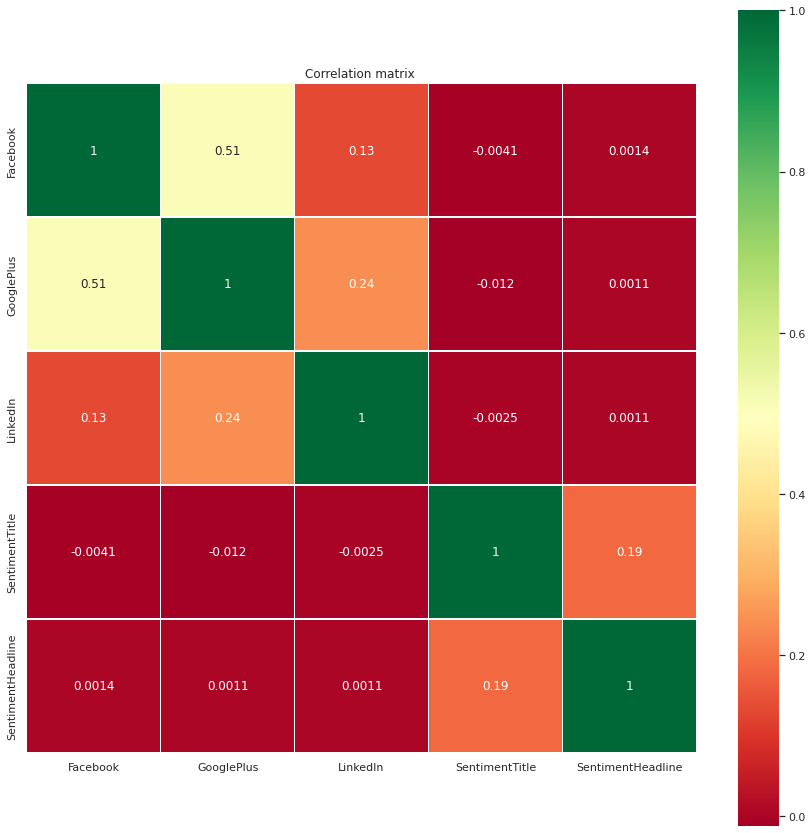

In [ ]:

plt.figure(figsize=(15,15))
_ = sns.heatmap(train[['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')

plt.show()

In [ ]:
train.columns

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'Facebook', 'GooglePlus', 'LinkedIn', 'SentimentTitle',
       'SentimentHeadline'],
      dtype='object')

In [ ]:
train.shape

(55757, 11)

In [ ]:
train.index

Int64Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,
               10,
            ...
            55922, 55923, 55924, 55925, 55926, 55927, 55928, 55929, 55930,
            55931],
           dtype='int64', length=55757)

Loading spacy English model

In [ ]:
nlp = English()

Custom Tokenizer

In [ ]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # here the token is converted into lowercase if it is a Pronoun and if it is not a Pronoun then it is lemmatized and lowercased    
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words using stopword from spacy library and punctuations from string library
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

Custom Transformer and text cleaner

In [ ]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        
        return [clean_text(text) for text in X]

    def fit(self, X, y, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
   
    return text.strip().lower()

In [ ]:
bow_vector = CountVectorizer(max_features = 100,tokenizer = spacy_tokenizer,ngram_range=(1,2))

In [ ]:
X_train_title = train.loc[:,'Title'].values
y_train_title = train.loc[:,['SentimentTitle']].values

X_train_headline = train.loc[:,'Headline'].values
y_train_headline = train.loc[:,['SentimentHeadline']].values

In [ ]:
X_test_title = test.loc[:,'Title'].values
X_test_headline = test.loc[:,'Headline'].values

In [ ]:
X_train_title.shape

(55757,)

In [ ]:
X_train_headline.shape

(55757,)

In [ ]:
y_train_headline.shape

(55757, 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train_title, x_valid_title, Y_train_title, y_valid_title = train_test_split(X_train_title, y_train_title, shuffle = True, test_size = 0.1)
x_train_headline, x_valid_headline, Y_train_headline, y_valid_headline = train_test_split(X_train_headline, y_train_headline, shuffle = True, test_size = 0.1)

In [ ]:
abs_y_train_title=np.sign(Y_train_title)
abs_y_train_headline=np.sign(Y_train_headline)
abs_y_valid_title=np.sign(y_valid_title)
abs_y_valid_headline=np.sign(y_valid_headline)

XGBoost Regressor


In [ ]:
xgboost = MultiOutputRegressor(XGBRegressor())
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=None,
                                                          random_state=0))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from datetime import date
import time

In [ ]:
pipe1 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', regr_multirf)])

pipe2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', regr_multirf)])

Title model generation

In [ ]:
pipe1.fit(x_train_title,Y_train_title)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7fb651ecc450>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=100, min_df=1, ngram_range=(1, 2),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 to...
                 MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                                      ccp_alpha=0.0,
                                                                      criterion='mse',
                                                                      max_depth=None,
      

In [ ]:
pipe2.fit(x_train_headline,Y_train_headline)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7fb651eccc10>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=100, min_df=1, ngram_range=(1, 2),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 to...
                 MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                                      ccp_alpha=0.0,
                                                                      criterion='mse',
                                                                      max_depth=None,
      

In [ ]:
test_pred_title=pipe1.predict(x_valid_title)

In [ ]:
test_pred_headline=pipe2.predict(x_valid_headline)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
mae_title=mean_absolute_error(y_valid_title,test_pred_title)

In [ ]:
mae_headline=mean_absolute_error(y_valid_headline,test_pred_headline)

In [ ]:
score=1-((0.4*mae_title)+(0.6*mae_headline))

In [ ]:
score

0.8991587445247826

In [ ]:
pred_title=pipe1.predict(X_test_title)

In [ ]:
pred_headline=pipe2.predict(X_test_headline)

In [ ]:
submission=pd.DataFrame()

In [ ]:
submissions['IDLink']=test['IDLink'].to_list()
submissions['SentimentTitle']=pred_title
submissions['SentimentHeadline']=pred_headline

In [ ]:
submission.head()

,IDLink,SentimentTitle,SentimentHeadline
0,tFrqIR6Chj,-0.032876,-0.032708
1,DVAaGErjlF,-0.017493,-0.049833
2,OT9UIZm5M2,-0.017493,-0.032203
3,lflGp3q2Fj,0.025084,-0.034146
4,zDYG0SoovZ,-0.126164,-0.018907


In [ ]:
import csv
%cd /content/

with open('submission.csv', 'r') as csvfile:
  reader = csv.reader(csvfile)
  rows = [row for row in reader]

print(rows)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import drive
from google.colab import drive
drive.mount('Sample_submissions',force_remount=True)
Output_dir = Root_DTR+'Problem/MyDrive/Problem/Sample_submissions'
base_dir = Output_dir + 'fastai-v3/'
print("saved Model to",Output_dir)

Mounted at Sample_submissions
saved Model to Problem/MyDrive/Problem/Problem/MyDrive/Problem/Sample_submissions
